In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar el modelo LSTM y el autoencoder
lstm_model = load_model('/content/best_model.h5')
autoencoder_model = load_model('/content/best_autoencoder.h5')

In [18]:
# Escalar los datos de entrenamiento
train_df = pd.read_csv('/content/train.csv')
test_df  = pd.read_csv('/content/test.csv', usecols=['date'])  # Cargar test_data sin la primera columna 'id'
# Convertir la columna 'date' a tipo datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
daily_sales = train_df.groupby('date').sum()['sales'].reset_index()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sales['sales'].values.reshape(-1, 1))

# Crear secuencias para LSTM
seq_length = 30
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

X = create_sequences(scaled_data, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Realizar predicciones con el LSTM
predictions = []
last_sequence = scaled_data[-seq_length:]

for _ in range(len(test_df['date'].unique())):
    last_sequence = last_sequence.reshape((1, seq_length, 1))
    next_prediction = lstm_model.predict(last_sequence)
    predictions.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_prediction[0]]], axis=1)

# Invertir la escala de las predicciones
predicted_sales = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Crear DataFrame con las predicciones futuras
prediction_dates = test_df['date'].unique()
predictions_df = pd.DataFrame({'date': prediction_dates, 'predicted_sales': predicted_sales.flatten()})


1/1 [==============================] - 0s 33ms/step


In [12]:

predictions_df

,date,predicted_sales
0,2018-01-01,21793.068359
1,2018-01-02,21886.062500
2,2018-01-03,22035.031250
3,2018-01-04,22396.800781
4,2018-01-05,22650.888672
...,...,...
85,2018-03-27,20256.677734
86,2018-03-28,20240.345703
87,2018-03-29,20224.269531
88,2018-03-30,20208.449219


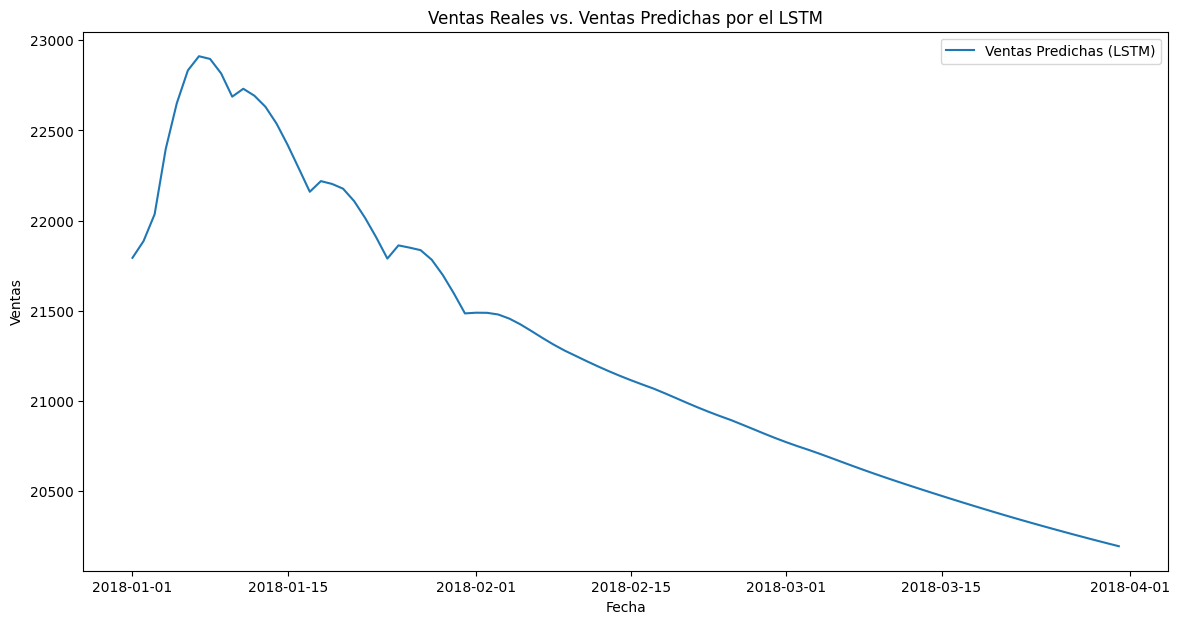

In [20]:
# Plotear las ventas reales y las ventas predichas
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(predictions_df['date'], predictions_df['predicted_sales'], label='Ventas Predichas (LSTM)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Reales vs. Ventas Predichas por el LSTM')
plt.legend()
plt.show()


Paso 3: Usar el Autoencoder para Detectar Anomalías en las Predicciones del LSTM


In [36]:
# Escalar las predicciones para el autoencoder
scaled_predictions = scaler.transform(predicted_sales)

# Crear secuencias para el autoencoder
pred_sequences = create_sequences(scaled_predictions, seq_length)

# Redimensionar las secuencias de predicciones para el autoencoder
pred_sequences = pred_sequences.reshape(pred_sequences.shape[0], pred_sequences.shape[1])

# Calcular el error de reconstrucción
pred_reconstruction = autoencoder_model.predict(pred_sequences)
pred_reconstruction = pred_reconstruction.reshape(pred_reconstruction.shape[0], pred_reconstruction.shape[1])

# Error de reconstrucción
reconstruction_error = np.mean(np.abs(pred_sequences - pred_reconstruction), axis=1)

# Establecer un umbral para la detección de anomalías
train_sequences = X.reshape(X.shape[0], X.shape[1])
train_reconstruction = autoencoder_model.predict(train_sequences)
train_reconstruction = train_reconstruction.reshape(train_reconstruction.shape[0], train_reconstruction.shape[1])

train_reconstruction_error = np.mean(np.abs(train_sequences - train_reconstruction), axis=1)

# Ajustar los umbrales utilizando la media y desviación estándar
mean_train_error = np.mean(train_reconstruction_error)
std_train_error = np.std(train_reconstruction_error)
threshold_upper = mean_train_error + 0.05 * std_train_error
threshold_lower = mean_train_error - 0.05 * std_train_error

# Identificar las anomalías en las predicciones futuras (tanto altas como bajas)
anomalies_upper = reconstruction_error > threshold_upper
anomalies_lower = reconstruction_error < threshold_lower
anomalies = anomalies_upper | anomalies_lower

# Mostrar las fechas de las anomalías en las predicciones futuras
anomalous_dates = prediction_dates[seq_length:][anomalies]

# Mostrar las ventas predichas en los días anómalos
anomalous_sales = predictions_df[predictions_df['date'].isin(anomalous_dates)]

# Crear un DataFrame con los valores finales
final_anomalies_df = pd.DataFrame({
    'date': anomalous_sales['date'],
    'predicted_sales': anomalous_sales['predicted_sales'],
    'reconstruction_error': reconstruction_error[anomalies]
})

# Mostrar los valores finales
print(final_anomalies_df)


57/57 [==============================] - 0s 1ms/step
         date  predicted_sales  reconstruction_error
30 2018-01-31     21484.726562              0.030146
31 2018-02-01     21488.539062              0.029835
32 2018-02-02     21487.986328              0.029316
33 2018-02-03     21478.679688              0.028955
34 2018-02-04     21455.943359              0.028924
35 2018-02-05     21424.037109              0.029099
36 2018-02-06     21386.777344              0.029016
37 2018-02-07     21348.279297              0.028695
38 2018-02-08     21311.593750              0.028763


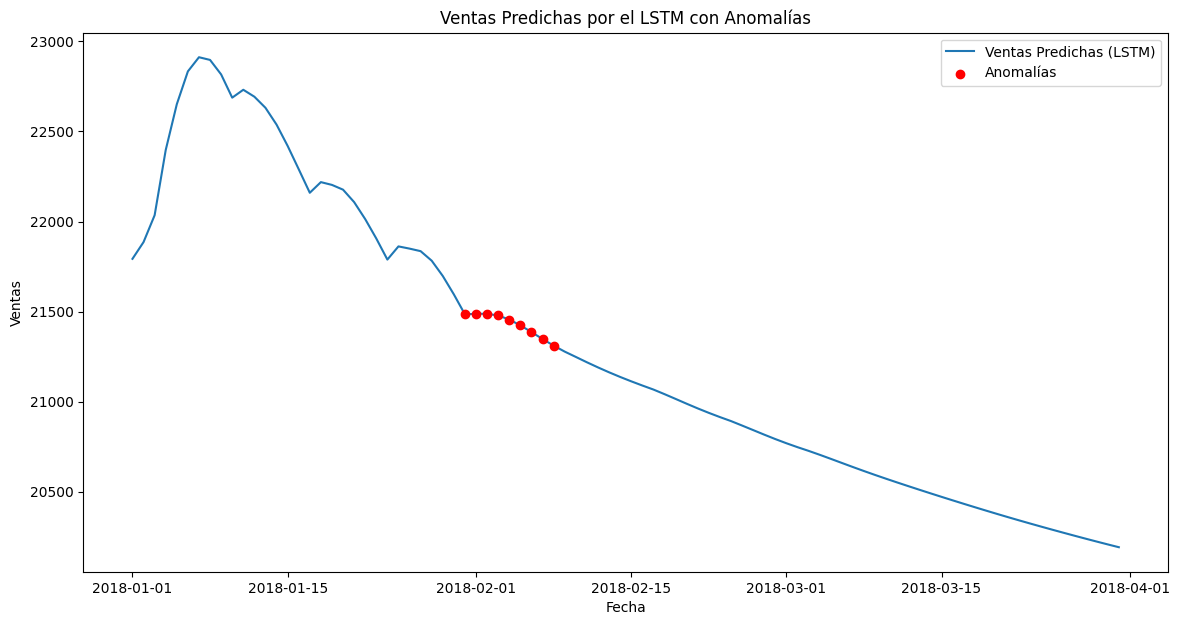

In [39]:
# Plotear solo las predicciones del LSTM y las anomalías
plt.figure(figsize=(14, 7))
plt.plot(predictions_df['date'], predictions_df['predicted_sales'], label='Ventas Predichas (LSTM)')

# Marcar las anomalías en el gráfico
plt.scatter(final_anomalies_df['date'], final_anomalies_df['predicted_sales'], color='red', label='Anomalías', zorder=5)


plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Predichas por el LSTM con Anomalías')
plt.legend()
plt.show()


In [40]:
# Comparar las ventas predichas del día anómalo en 2018 con las ventas del mismo día en 2017
comparison_results = []

for anomaly_date in anomalous_sales['date']:
    year_2017_date = anomaly_date.replace(year=2017)
    year_2017_sales = daily_sales[daily_sales['date'] == year_2017_date]['sales'].values
    year_2018_sales = anomalous_sales[anomalous_sales['date'] == anomaly_date]['predicted_sales'].values
    if year_2017_sales.size > 0:
        comparison_results.append({
            'date': anomaly_date,
            '2017_sales': year_2017_sales[0],
            '2018_predicted_sales': year_2018_sales[0]
        })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

        date  2017_sales  2018_predicted_sales
0 2018-01-31       18486          21484.726562
1 2018-02-01       20612          21488.539062
2 2018-02-02       21875          21487.986328
3 2018-02-03       23501          21478.679688
4 2018-02-04       25018          21455.943359
5 2018-02-05       26084          21424.037109
6 2018-02-06       17584          21386.777344
7 2018-02-07       20433          21348.279297
8 2018-02-08       20292          21311.593750


In [ ]:
comparison_df